<a href="https://colab.research.google.com/github/Robert-Gomez-DS/Understanding-the-role-of-individual-units-in-DNN/blob/main/DissectionVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
! pip install transformers 
pip install ninja 2>> install.log

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 4.6 MB/s eta 0:00:00


---

# Net dissection on VGG 

In this notebook we want to share the process of net dissection on a particular convolutional neural network architecture. In this case we are going to work in VGG16, a renowned CNN that won the ILSVRC in 2014 a classification challenge with the imageNet dataset, we want to understand the role of units of this CNN in terms of human concepts of the classification process also we want to provide some interpretabilty for this modet, that is why we want to do a netdissect on VGG16.

To start we use a modification of net dissect library who the authors of the paper did, to make that works with the actual versions we fork the github repository and fix the compatibility problems, for this reason we clone our own version of net dissect library

In [2]:
%%bash
git clone -b main https://github.com/Robert-Gomez-DS/global-model-repr.git 

Cloning into 'global-model-repr'...


In [3]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    sys.path.append('./global-model-repr/') 
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")  
except:
    pass

In [4]:
import sys, scipy 
sys.path.append('./global-model-repr/') 

Now we import our version of netdissection,torch to use pytorch, also we import transformers to use an simple segmenter.

In [5]:
import torch, os, matplotlib.pyplot as plt
from transformers import pipeline
from netdissect import nethook, imgviz, show, segmenter, renormalize, upsample, tally, pbar
from netdissect import setting
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(False) 

/content/./global-model-repr/netdissect/segmenter.py:325: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  assert result is not 0, 'unrecognized class %d' % classnum


## VGG-16

Now we download a dataset for which we use VGG16 to classify and who allows us to dissect the network.

**What is VGG16**

VGG16 is a convolutional neural network (CNN) architecture that was proposed by the Visual Geometry Group (VGG) at the University of Oxford. It gained significant popularity and achieved outstanding performance in image classification tasks, particularly in the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) in 2014.





<div style="display: flex; width: 100%;">
  <div style="flex: 4;width:10%;padding-left: 10px;">
      The architecture of VGG16 consists of 16 layers, hence the name. It follows a straightforward design principle of using small-sized convolutional filters (3x3) throughout the network, stacked together to form deeper representations. This uniformity in filter size allows for a deeper network with a simpler structure.
  </div>
  <div style="flex: 6;width:90%; padding-right: 10px;">
    <img src="https://github.com/Robert-Gomez-DS/Understanding-the-role-of-individual-units-in-DNN/blob/main/illu_VGG-02.png?raw=1" alt="Descripción de la imagen" style="width: 100%;">
  </div>
  
</div>

100%|██████████| 499777515/499777515 [00:17<00:00, 29148250.64it/s]


Extracting datasets/places_val.zip to datasets



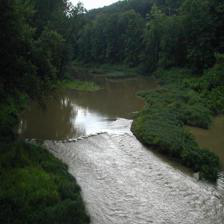

In [6]:
ds = setting.load_dataset('places', 'val')
iv = imgviz.ImageVisualizer(224, source=ds, percent_level=0.99)
show(iv.image(ds[0][0]))

Now we are going to load the model VGG16 with architecture and weights , this is for study and interpretabilty

In [7]:
model = setting.load_vgg16()
model = nethook.InstrumentedModel(model)

renorm = renormalize.renormalizer(source=ds, target='zc')
ivsmall = imgviz.ImageVisualizer((56, 56), source=ds, percent_level=0.99)


Downloading: "http://gandissect.csail.mit.edu/models/vgg16_places365-6e38b568.pth" to /root/.cache/torch/hub/checkpoints/vgg16_places365-6e38b568.pth
100%|██████████| 518M/518M [00:18<00:00, 28.8MB/s]


Now we want to print the architecture of VGG16 model.

In [8]:
print(model)

InstrumentedModel(
  (model): VGG(
    (features): Sequential(
      (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_1): ReLU(inplace=True)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_2): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_1): ReLU(inplace=True)
      (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_2): ReLU(inplace=True)
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_1): ReLU(inplace=True)
      (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_2): ReLU(inplace=True)
      (conv3_3): Conv2d(256, 256, ker

Now we want to introduce VGG16 and how the paper works with it, our objective is to extract semantic information about units in the neural network,the paper shows that 

We want to see the predictions that the model do with the images.

310



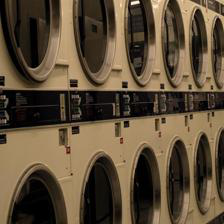
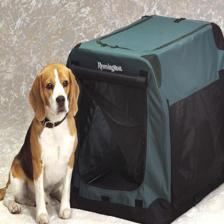
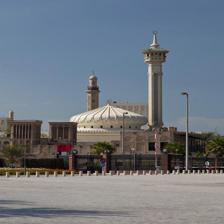
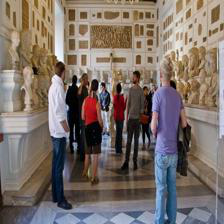
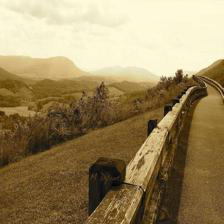
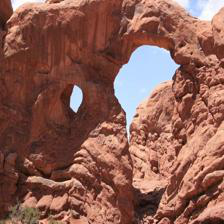
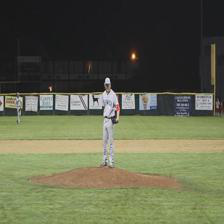
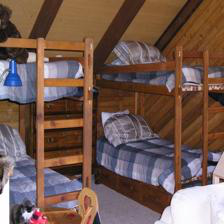
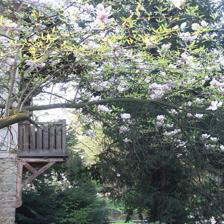
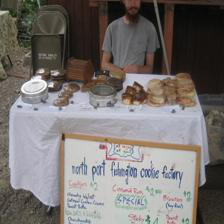
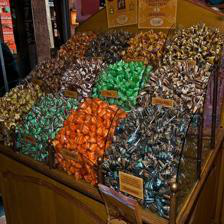
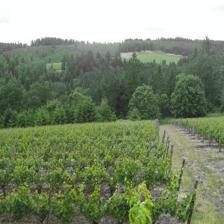

In [16]:
target_class = ds.classes.index('soccer_field')
print(target_class)
indexes = range(100, 112)
batch = torch.stack([ds[i][0] for i in indexes])
_, preds = model(batch).max(1)
show([[
    iv.image(batch[j]),
    'label: ' + ds.classes[ds[i][1]],
    'pred: ' + ds.classes[preds[j]],
    i,
] for j, i in enumerate(indexes)])

In [ ]:
if False:
    correct = 0
    tested = 0
    for imagebatch, labelbatch in pbar(torch.utils.data.DataLoader(ds, batch_size=100)):
        modelpreds = model(imagebatch).max(1)[1]
        print(modelpreds.cpu(), labelbatch)
        correct += (modelpreds.cpu() == labelbatch).sum() # fixme
        tested += len(labelbatch)
    print('%d correct out of %d' % (correct, tested))


We are going to work with the layer 4 this is because the paper show that is the layer who activates more in the regions of objects so is more visibile for our case.

torch.Size([12, 512, 28, 28])



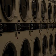
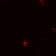
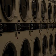
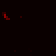
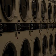
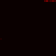
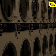
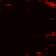
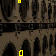
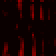
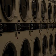
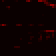
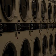
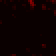
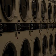
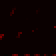
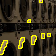
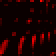
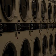
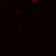
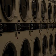
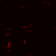
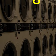
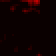
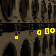
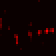
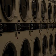
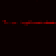
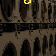
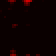
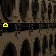
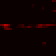
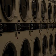
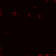
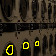
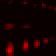
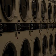
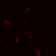
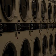
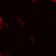
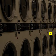
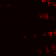
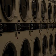
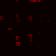
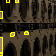
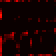
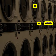
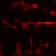


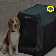
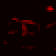
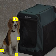
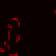
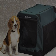
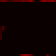
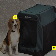
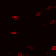
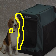
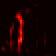
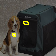
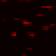
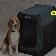
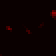
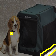
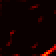
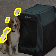
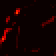
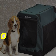
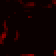
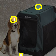
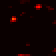
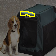
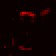
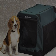
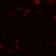
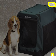
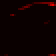
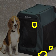
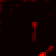
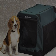
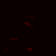
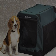
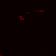
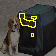
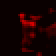
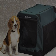
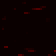
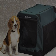
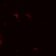
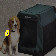
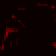
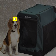
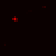
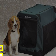
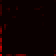
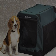
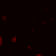


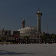
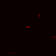
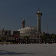
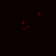
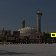
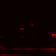
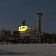
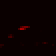
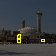
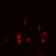
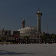
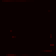
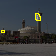
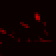
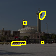
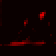
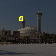
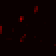
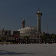
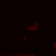
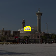
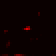
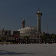
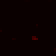
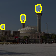
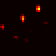
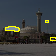
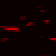
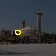
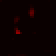
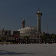
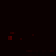
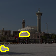
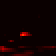
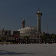
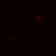
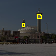
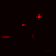
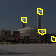
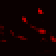
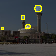
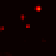
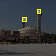
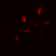
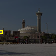
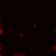
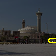
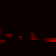


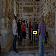
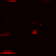
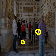
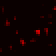
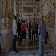
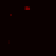
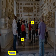
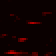
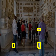
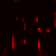
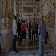
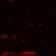
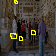
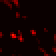
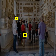
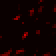
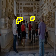
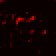
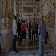
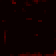
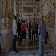
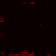
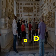
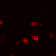
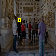
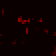
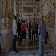
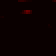
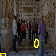
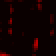
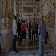
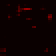
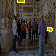
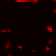
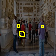
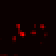
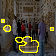
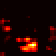
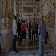
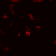
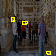
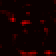
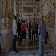
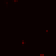
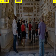
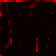
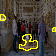
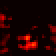


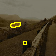
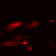
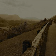
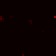
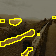
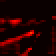
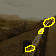
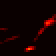
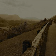
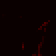
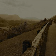
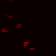
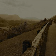
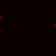
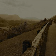
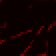
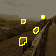
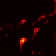
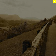
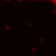
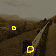
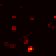
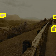
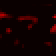
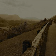
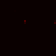
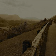
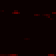
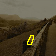
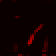
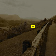
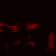
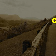
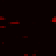
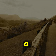
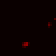
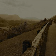
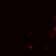
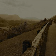
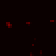
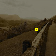
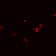
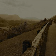
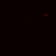
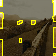
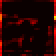
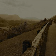
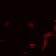


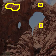
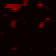
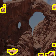
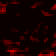
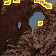
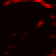
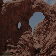
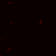
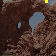
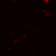
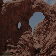
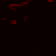
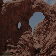
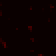
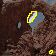
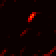
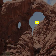
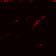
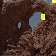
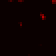
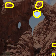
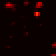
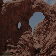
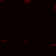
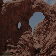
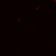
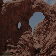
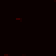
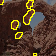
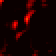
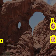
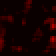
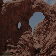
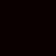
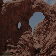
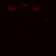
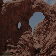
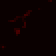
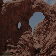
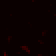
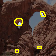
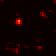
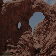
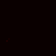
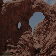
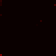
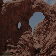
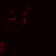


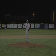
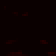
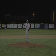
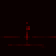
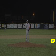
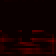
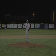
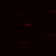
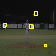
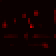
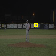
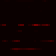
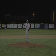
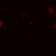
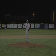
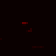
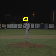
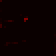
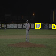
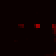
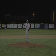
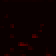
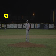
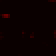
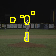
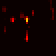
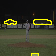
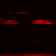
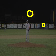
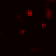
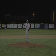
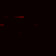
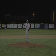
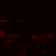
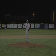
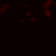
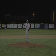
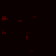
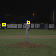
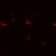
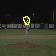
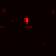
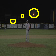
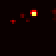
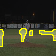
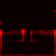
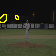
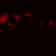

In [11]:
layername = 'features.conv4_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in range(1,acts.shape[1]//10 -2,2)
    
    for imagenum in [i]
])

torch.Size([12, 512, 28, 28])



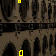
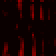
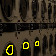
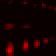
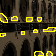
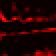
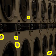
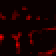


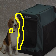
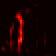
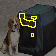
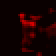
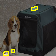
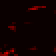
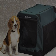
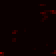


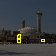
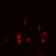
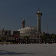
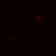
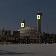
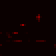
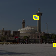
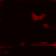


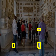
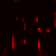
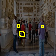
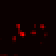
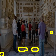
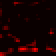
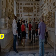
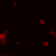


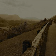
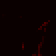
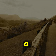
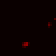
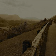
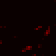
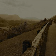
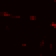


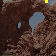
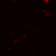
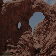
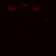
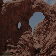
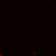
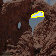
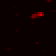


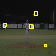
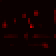
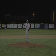
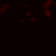
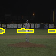
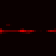
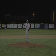
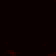

In [12]:
layername = 'features.conv4_3'
model.retain_layer(layername)
model(batch)
acts = model.retained_layer(layername).cpu()
print(acts.shape)
for i in range(7):
    show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in [9,35,298,315]
    
    for imagenum in [i]
])

In [17]:
upfn = upsample.upsampler(
    target_shape=(56, 56),
    data_shape=(7, 7),
)

def flatten_activations(batch, *args):
    image_batch = batch
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    hacts = upfn(acts)
    return hacts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

rq = tally.tally_quantile(
    flatten_activations,
    dataset=ds,
    sample_size=1000,
    batch_size=100,
    cachefile='results/rq_cache.npz')

/usr/local/lib/python3.10/dist-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


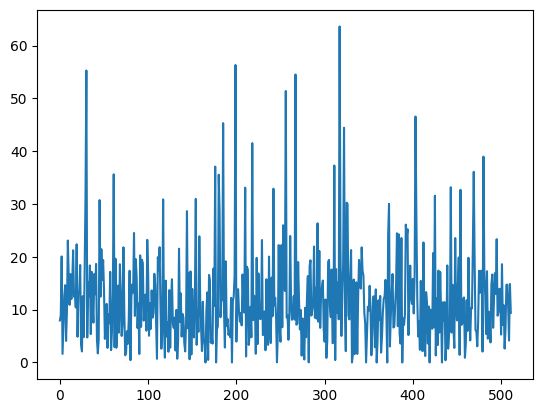

In [18]:

plt.plot(rq.quantiles(0.9))


Examine images that activate most each unit

Given a sample $n$ the next loop identifies the unit who activate strongest with some image.

In [20]:
sample_size = 1000

def max_activations(batch, *args):
    image_batch = batch
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).max(2)[0]

def mean_activations(batch, *args):
    image_batch = batch
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).mean(2)

topk = tally.tally_topk(
    mean_activations,
    dataset=ds,
    sample_size=sample_size,
    batch_size=100,
    cachefile='results/cache_mean_topk.npz'
)

top_indexes = topk.result()[1]

Now we run a loop that runs the model for each of the top-activating images for the unit $u$ and show where the unit activates within each image.


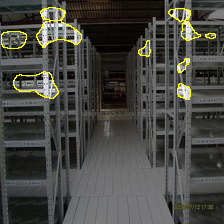
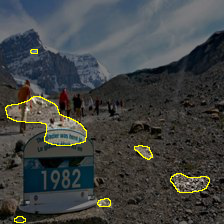
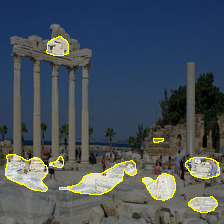
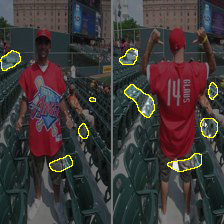
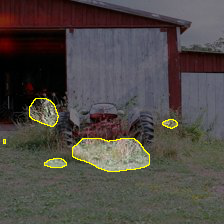
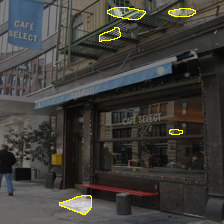
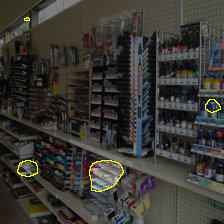
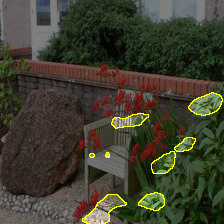
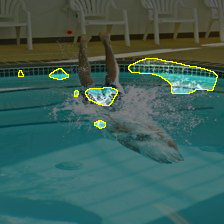
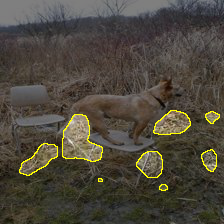
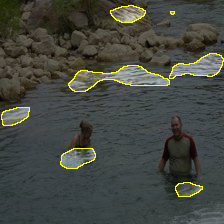
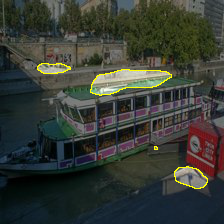
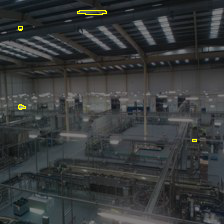
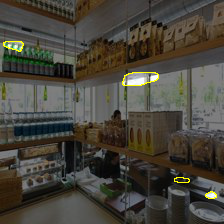
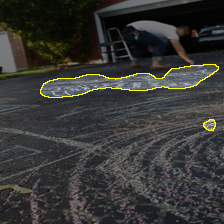
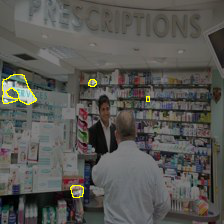
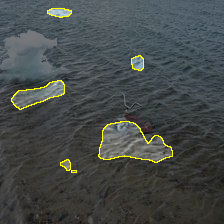
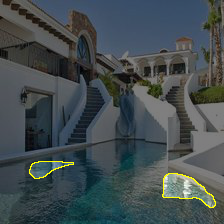
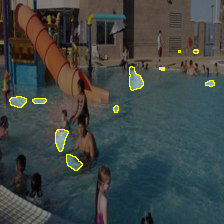
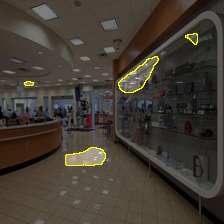

In [22]:
show.blocks([
    ['unit %d' % u,
     'img %d' % i,
     'pred: %s' % ds.classes[model(ds[i][0][None]).max(1)[1].item()],
     [iv.masked_image(
        ds[i][0],
        model.retained_layer(layername)[0],
        u)]
    ]
    for u in [12]
    for i in top_indexes[u, :20]
])

The following code automates the above process for all the units, collecting a visualization of top images for each unit in the network.

In [24]:
def compute_activations(image_batch, label_batch):
    image_batch = image_batch
    _ = model(image_batch)
    acts_batch = model.retained_layer(layername)
    return acts_batch

unit_images = iv.masked_images_for_topk(
    compute_activations,
    ds,
    topk,
    k=5,
    num_workers=10,
    pin_memory=True,
    cachefile='results/cache_top10images.npz')

Now we introduce a segmentation algorithm to make the operation

In [ ]:
 segmenter = pipeline("image-segmentation", model="my_awesome_seg_model")